# Minimal implementation of the *clusterITE* library

### Generate Data

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ortho_group

In [2]:
# Sample a 2x2 orthonormal matrix
orth_mat = ortho_group.rvs(dim=2)

# Create a 2x2 positive semi-definite matrix with eigenvalues 2 and 3
sigma_mat = orth_mat @ np.diag([2, 3]) @ orth_mat.T

# Sample 1000 points from a 2D Gaussian
X = np.random.multivariate_normal(mean=[0, 0], cov=sigma_mat, size=1000)

In [3]:
# Create parameters for the probability of belonging to each of the 3 clusters
cl1_param = np.array([-9, -8])
cl2_param = np.array([9, 8])
cl3_param = np.array([-4, 2])

cl_param = np.array([cl1_param, cl2_param, cl3_param])

In [4]:
# Create these probabilities for each point
def softmax(X, cl_param, k):
    return np.exp(X @ cl_param[k]) / np.sum([np.exp(X @ cl_param[i]) for i in range(cl_param.shape[0])], axis=0)

def all_softmax(X, cl_param):
    return np.array([softmax(X, cl_param, k) for k in range(cl_param.shape[0])]).T

cluster_prob = all_softmax(X, cl_param)
cluster_prob

array([[1.75392451e-04, 9.97235813e-01, 2.58879474e-03],
       [9.99854386e-01, 1.41685109e-08, 1.45599421e-04],
       [8.34742400e-01, 4.19214537e-05, 1.65215679e-01],
       ...,
       [5.42442499e-33, 1.00000000e+00, 3.11470597e-21],
       [7.23528801e-14, 9.95297280e-01, 4.70272014e-03],
       [3.05047374e-10, 9.82764751e-01, 1.72352489e-02]])

NB: we picked parameters so that the real probabilities above are close to 0 or 1. This is merely for simplicity of the illustration, and could straightforwardly be complexified.

In [5]:
# For the real clusters, sample one hot encoded random vectors from a multinomial distribution
cluster_real_oh = np.array([np.random.multinomial(n=1, pvals=cluster_prob[i]) for i in range(cluster_prob.shape[0])])
cluster_real_oh

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [6]:
# Convert one hot encoding to categorical
cluster_real_cat = cluster_real_oh.argmax(axis=1)

# Number of points in each cluster
np.unique(cluster_real_cat, return_counts=True)

(array([0, 1, 2]), array([458, 443,  99]))

In [7]:
# Create parameters for each of the 3 experts
ex1_param = np.array([-.1, .8])
ex2_param = np.array([-.3, .5])
ex3_param = np.array([-.6, .3])

# Store the parameters in a 3x2 matrix
ex_param = np.array([ex1_param, ex2_param, ex3_param])

In [8]:
# Create all predictions for the 3 experts for all points
# To mimic individualized treatment effects (ITEs), bound the predictions between -1 and +1 like so
ex_preds = 2 * np.array([1 / (1 + np.exp(-X @  ex_param[ex])) for ex in range(ex_param.shape[0])]) - 1 

ex_preds.shape, (np.min(ex_preds), np.max(ex_preds))

((3, 1000), (-0.9537830352011586, 0.9415458463822326))

In [9]:
# Pick as real ITE the prediction from the corresponding cluster
# by applying the one-hot encoding mask like so
y = np.sum(ex_preds.T * cluster_real_oh, axis=1)
y.shape, (np.min(y), np.max(y))

((1000,), (-0.9458654741723881, 0.9262001634058012))

### Minimal implementation

In [10]:
from clusterITE import *

2023-08-17 00:26:46.983934: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 1. All parametric

100%|██████████| 14/14 [00:49<00:00,  3.53s/it]


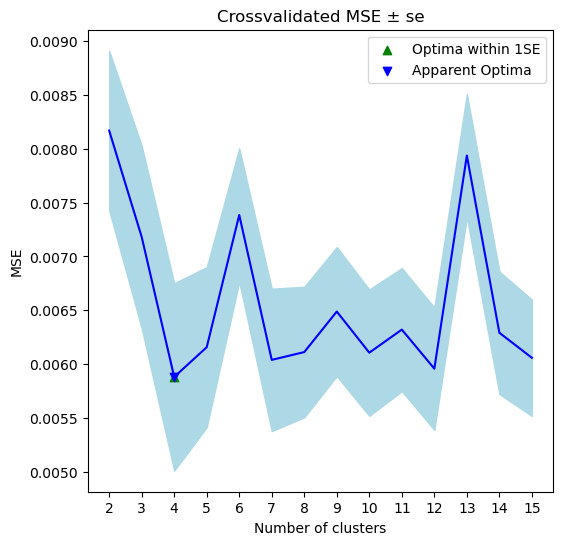

In [ ]:
# Instanciate a ClusterIte model with 5 fold cross-validation
cv_model = ClusterIte_cv(nb_folds=5)

# Specify a range for the no. of clusters and fit this model to the data
cv_model.fit(X,y, cluster_range = range(2,16))

# Plot the result
cv_model.plot()

In [ ]:
# Instanciate a ClusterIte model with the optimal K estimated from cross-validation
final_model = ClusterIte(K=cv_model.best_K)

# Instanciate this model on all the training data
final_model.fit(X, y)

Converged at iteration 2 with accuracy on H 99.70%


#### 2. Non-parametric

In [11]:
# For the gating network, define any Keras/Tensorflow architecture of your choice
def custom_tf_model(n_clusters):
    model = Sequential()
    ## Write your favorite architecture here...
    ## ... but make sure to finish the network like so
    model.add(Dense(n_clusters, use_bias=True, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

# For the expert networks, define any sklearn architecture of your choice
# and store both expert and gating network in a dictonary
base_learners = {'experts': RandomForestRegressor(n_estimators=100, max_depth=10, max_features=10),
                 'gating_net': custom_tf_model}

In [14]:
base_learners = {'experts': RandomForestRegressor(n_estimators=100, max_depth=10, max_features=10),
                 'gating_net': custom_tf_model}

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [05:40<00:00, 24.29s/it]


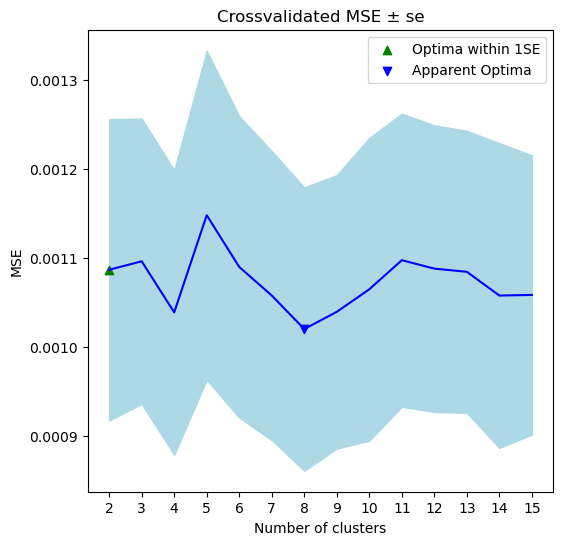

In [15]:
# Instanciate a ClusterIte model with 5 fold cross-validation
cv_model = ClusterIte_cv(nb_folds=5, **base_learners)

# Specify a range for the no. of clusters and fit this model to the data
cv_model.fit(X,y, cluster_range = range(2,16))

# Plot the result
cv_model.plot()

In [16]:
# Instanciate a ClusterIte model with the optimal K estimated from cross-validation
final_model = ClusterIte(K=cv_model.best_K, **base_learners)

# Instanciate this model on all the training data
final_model.fit(X, y)

Converged at iteration 2 with accuracy on H 100.00%
